In [1]:
# Imports and Defines

# imports
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import ast

from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


# pip install timeseries-cv
from tsxv import splitTrain
from time import strftime
from collections import OrderedDict
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.gridspec as gridspec
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
previousStepsToShow = 15;

# Define Univariate Time-Series to study
stepsToForecast = [1, 3, 12]

# Read CSV file and parse dates
df = pd.read_csv('Consumer_all_items_normal.csv', parse_dates=['date'], index_col=['date'])

# Subset the data by date range
df = df.loc['1996-11-01':'2023-02-01']


# Split the data into train and test sets
df_train = df[['value']][:-stepsToForecast[-1]].rename(columns={'value': 'train'})
df_test = df[['value']][-stepsToForecast[-1]:].rename(columns={'value': 'test'})


title = 'CPI: Historical inflation rate'
serie = "CPI"
xlab = 'Months/Year'; 
ylab = 'Historical inflation rate';
seasonal_periods=12;

model_type = 'multiplicative'

In [3]:
df.head()

,value
date,
1996-11-01,67.8
1996-12-01,67.8
1997-01-01,67.5
1997-02-01,67.9
1997-03-01,68.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 1996-11-01 to 2023-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   316 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [5]:
# Summary statistics
print(df.describe(percentiles=[.1, .25, .5, .75, .9]))
print("var    %.6f" % np.var(df))

            value
count  316.000000
mean    92.795253
std     11.993258
min     67.500000
10%     71.100000
25%     85.400000
50%     98.300000
75%    100.900000
90%    102.350000
max    116.700000
var    143.383047


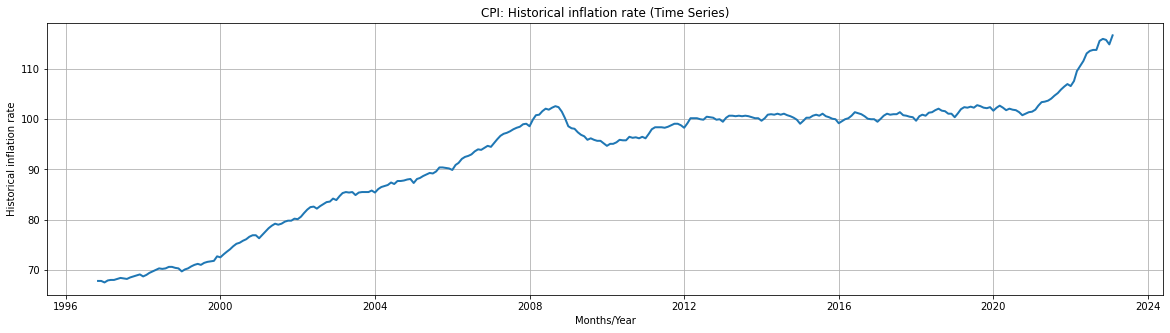

In [6]:
# Data Visualization

# Let's visualize the data to have an idea of what we are looking at
plt.figure(figsize=(20,5))
plt.plot(df.index, df.values, linewidth=2)
plt.title(title + ' (Time Series)')
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid(True)

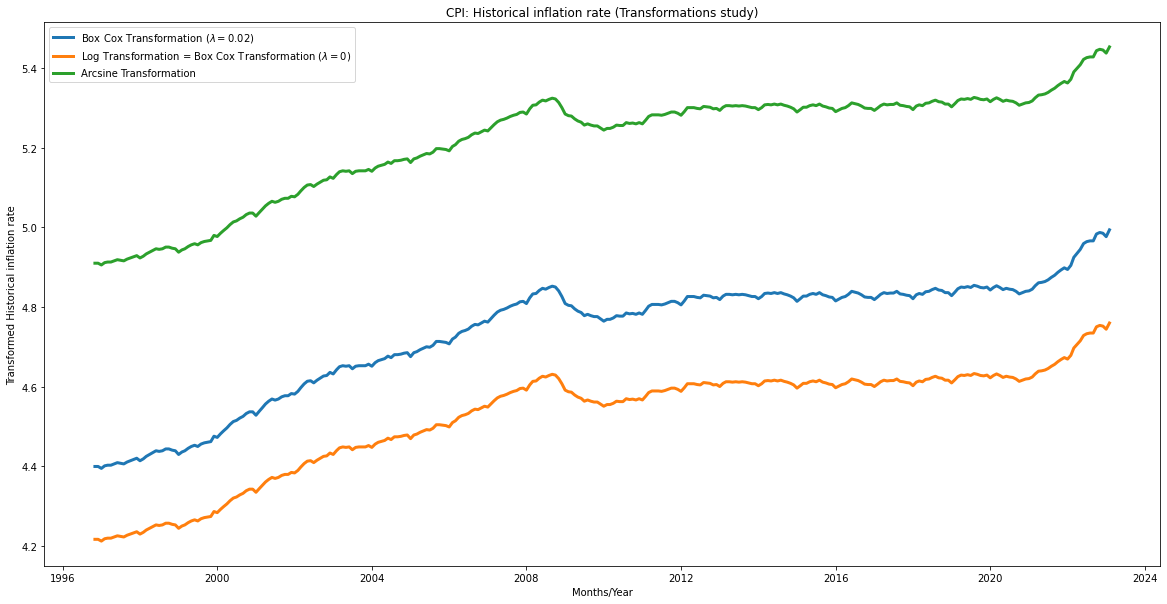

In [7]:
# Data Normalization
fig = plt.figure(figsize=(20,10))
# The Box-Cox transformation intends to transform data to be closer to normality, 
#or tranform heteroskedastic (non constant variance) data to be closer to homoskedasticity (constant variance).
plt.plot(df.index, stats.boxcox(df[df.columns[0]].values, lmbda=.02), label = 'Box Cox Transformation '+u'($\lambda=0.02$)', lw=3)

#the transform is likely to make variance more constant and normalize data
plt.plot(df.index, stats.boxcox(df[df.columns[0]].values, lmbda=0), label = 'Log Transformation = Box Cox Transformation '+u'($\lambda=0$)', lw=3)
# The arcsine transformation will help make the variances more constant throughout 
#your study area and often makes the data appear normally distributed as well.
plt.plot(df.index, np.arcsinh(df[df.columns[0]].values), label = 'Arcsine Transformation', lw=3)

plt.legend(loc='best')
plt.title(title + ' (Transformations study)')
plt.xlabel(xlab)
plt.ylabel('Transformed ' + ylab);

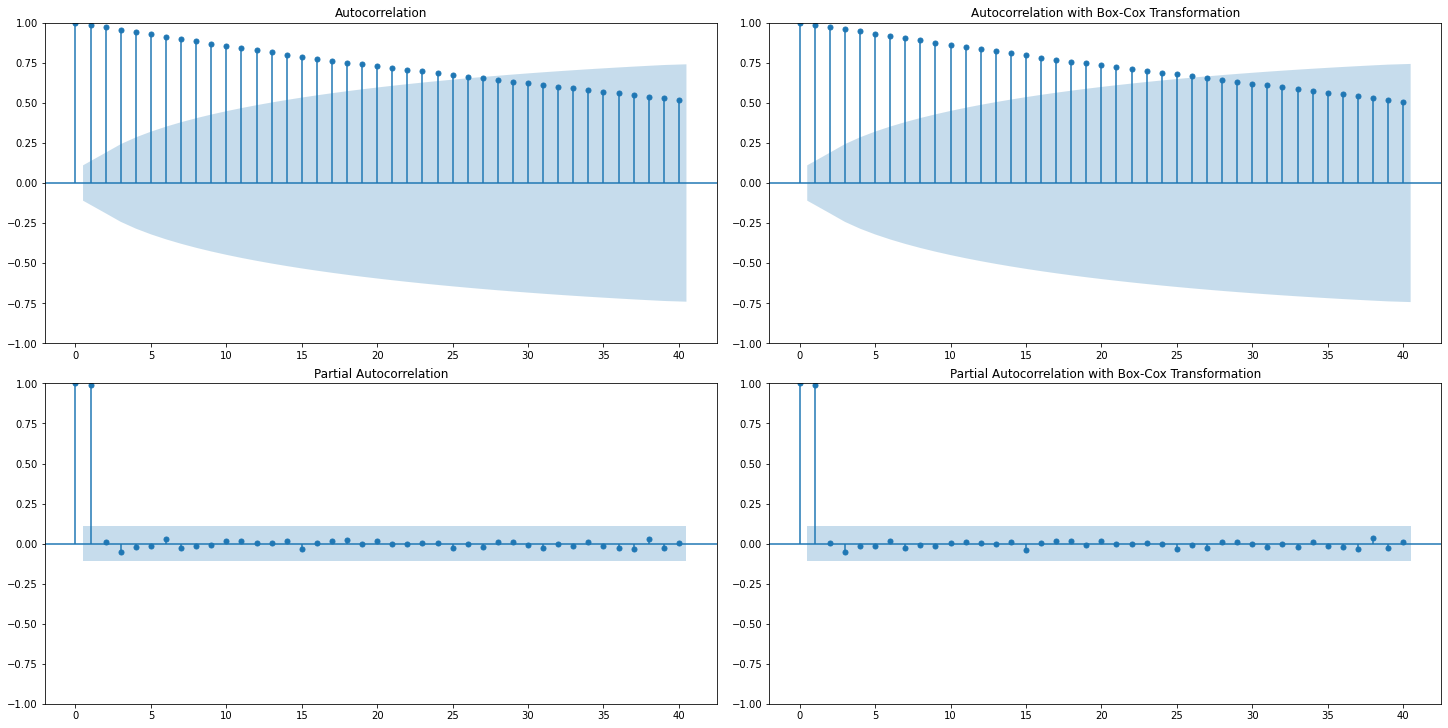

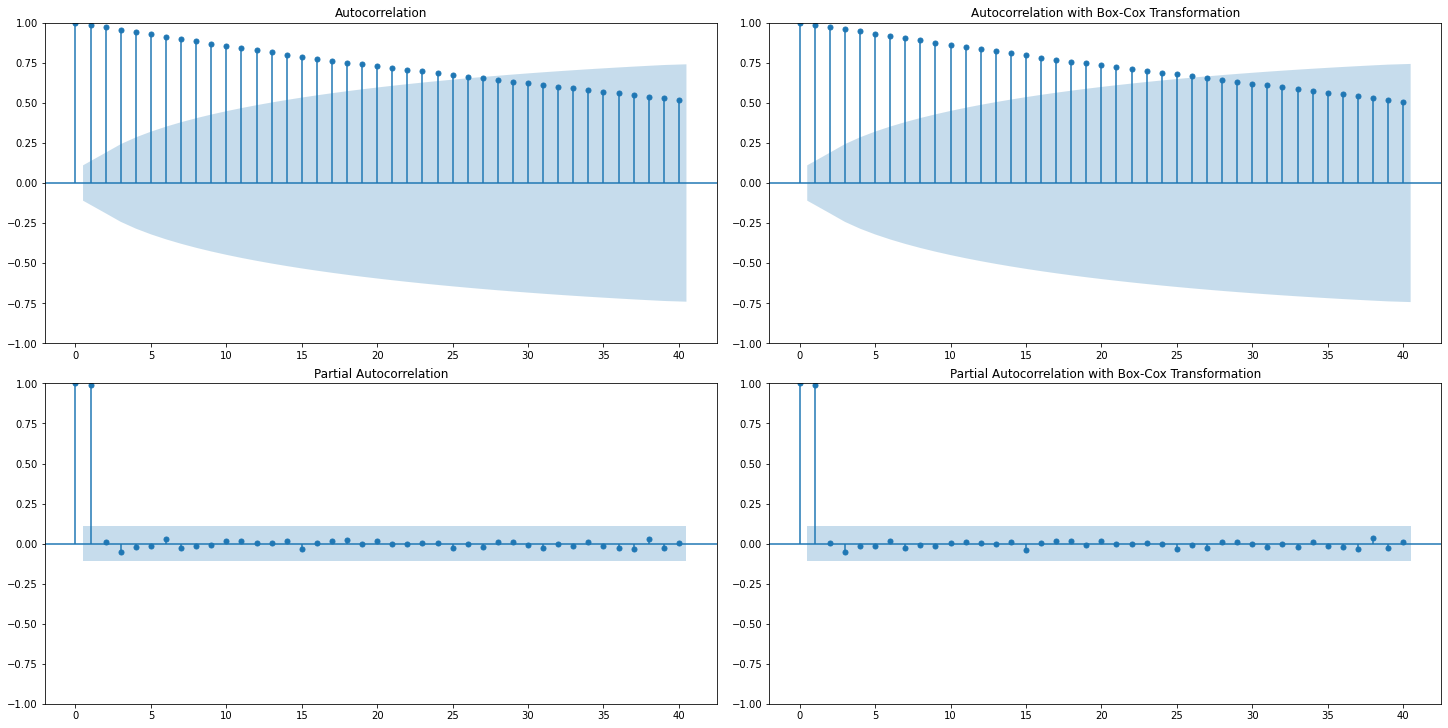

In [8]:
# Correlation plots
maxLags = 40
# The effect of applying Box-Cox transformation against original time series
df_boxCox = stats.boxcox(df[df.columns[0]].values, lmbda=0)

fig = plt.figure(figsize=(20,10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df, lags=maxLags, ax=ax_acf)
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df, lags=maxLags, ax=ax_pacf);

# Auto-correlation function for time series transformed with Box-Cox
ax_acfBoxCox = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(df_boxCox, lags=maxLags, ax=ax_acfBoxCox, title='Autocorrelation with Box-Cox Transformation')
# Partial auto-correlation function for time series transformed with Box-Cox
ax_pacfBoxCox = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(df_boxCox, lags=maxLags, ax=ax_pacfBoxCox, title='Partial Autocorrelation with Box-Cox Transformation')

In [9]:
def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return

In [10]:
# Compute MAE over an array of different horizons
def horizon_mae(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[0,:i]), 2))
    return list_MAE;

In [11]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true.T) / y_true.T));

In [12]:
# Compute MAPE over an array of different horizons
def horizon_mape(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[0,:i]), 2))
        return list_MAPE;

In [13]:
def replace_initial_outliers(df, numInitialSamples, valToReplace, outlierConstant):
    df_resNew = df.copy()
    upper_quartile = np.percentile(df_resNew.values, 75)
    lower_quartile = np.percentile(df_resNew.values, 25)
    
    # Interquantile Range
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    lower_quartileBound = lower_quartile - IQR
    upper_quartileBound = upper_quartile + IQR
    
    outliers = []
    for ix in range(0, numInitialSamples):
        if (df_resNew.values[ix] < lower_quartileBound or df_resNew.values[ix] > upper_quartileBound):
            outliers.append((df_res.index[ix].strftime("%Y-%m-%d"), df_res.values[ix][0]))
            df_resNew.values[ix] = valToReplace
            
    return df_resNew, outliers

In [14]:
# Evaluate combinations of p, d and q values for a SARIMA model
def SARIMA_grid(dataset, sarimaCfg, isLog):
    df_IC = pd.DataFrame(columns=['SARIMA(p,d,q)t(P,D,Q,m)', 'AIC', 'BIC', 'HQIC'])
    df_IC = df_IC.set_index('SARIMA(p,d,q)t(P,D,Q,m)')
    dict_sarimaFit  = {} 
    dict_sarimaPred = {}
    modelNum = 0;
    totalModelNum = len(sarimaCfg.p_range)*len(sarimaCfg.d_range)*len(sarimaCfg.q_range)*len(sarimaCfg.t_range)* \
                        len(sarimaCfg.P_range)*len(sarimaCfg.D_range)*len(sarimaCfg.Q_range)*len(sarimaCfg.m_range)
    for p in sarimaCfg.p_range:
        for d in sarimaCfg.d_range:
            for q in sarimaCfg.q_range:
                order = (p,d,q)
                for t in sarimaCfg.t_range:
                    for P in sarimaCfg.P_range:
                        for D in sarimaCfg.D_range:
                            for Q in sarimaCfg.Q_range:
                                for m in sarimaCfg.m_range:
                                    seasonal_order = (P,D,Q,m)
                                    modelNum+=1;
                                    print("%d/%d " % (modelNum, totalModelNum))
                                     
                                    try:
                                        model = SARIMAX(dataset, order=order, \
                                                                 trend=t,     \
                                                                 seasonal_order=seasonal_order);
                                        model_fit = model.fit(disp=0);
                                        
                                        if (~np.isnan(model_fit.mle_retvals.get('fopt'))):
                                              
                                            model_str = 'SARIMA' + str(order) + str(t) + str(seasonal_order)
                                            df_IC = df_IC.append(pd.DataFrame({'AIC':model_fit.aic, 'BIC':model_fit.bic, \
                                                                               'HQIC':model_fit.hqic}, index =[model_str]), ignore_index=False)

                                            if (isLog):
                                                dict_sarimaFit[model_str]  = np.e**(model_fit.predict(typ='levels'));
                                                dict_sarimaPred[model_str] = np.e**(model_fit.forecast(steps=stepsToForecast[-1]));
                                            else:
                                                dict_sarimaFit[model_str]  = model_fit.predict(typ='levels');
                                                dict_sarimaPred[model_str] = model_fit.forecast(steps=stepsToForecast[-1]);
                                    except:
                                        continue
    return dict_sarimaFit, dict_sarimaPred, df_IC

# Stationarity of the Time-Series

Data transformation and its graphical representation This section allows to understand the representation of the series after its transformation to achieve stationarity

Box-Cox transformations such as the logarithmic one can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. Note: The order Box-Cox transformation, and then, differencing, is important!

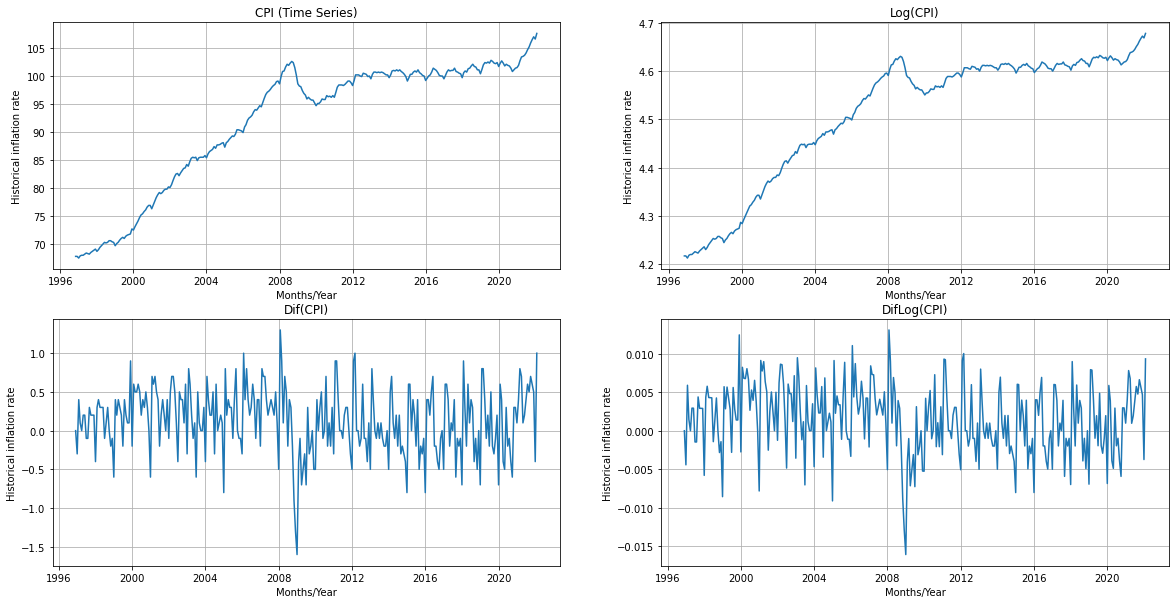

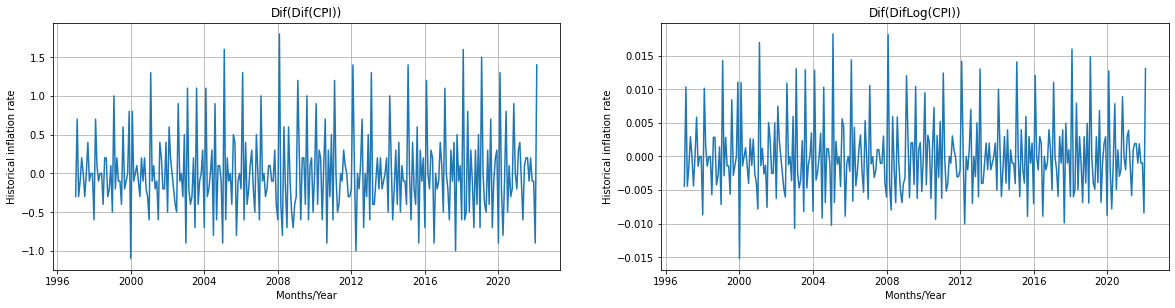

In [15]:
fig = plt.figure(figsize=(20, 10))

fig.add_subplot(221)
plt.title(serie + ' (Time Series)')
plt.plot(df_train)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(222)
plt.title('Log(' + serie + ')')
plt.plot(np.log(df_train))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(223)
plt.title('Dif(' + serie + ')')
plt.plot(df_train.diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(224)
plt.title('DifLog(' + serie + ')')
plt.plot(np.log(df_train).diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()


fig2 = plt.figure(figsize=(20, 10))
fig2.add_subplot(221)
plt.title('Dif(Dif(' + serie + '))')
plt.plot(df_train.diff().diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig2.add_subplot(222)
plt.title('Dif(DifLog(' + serie + '))')
plt.plot(np.log(df_train).diff().diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()


plt.show()


# Normality tests

Jarque-Bera Perform the Jarque-Bera goodness of fit test on sample data. The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

In [16]:
# Original data
jb_orig, jbpval_orig = stats.jarque_bera(df_train)
print("Jarque-Bera Test for " + serie)
print("Statistic: %.4f" % jb_orig)
print("p-value: %.4f" % jbpval_orig)
print("")

# Log transformation
df_log = np.log(df_train)
jb_log, jbpval_log = stats.jarque_bera(df_log)
print("Jarque-Bera Test for Log(" + serie + ")")
print("Statistic: %.4f" % jb_log)
print("p-value: %.4f" % jbpval_log)
print("")

# First difference
df_diff = df_train.diff().dropna()
jb_diff, jbpval_diff = stats.jarque_bera(df_diff)
print("Jarque-Bera Test for Diff(" + serie + ")")
print("Statistic: %.4f" % jb_diff)
print("p-value: %.4f" % jbpval_diff)
print("")

# Log transformation followed by first difference
df_log_diff = np.log(df_train).diff().dropna()
jb_log_diff, jbpval_log_diff = stats.jarque_bera(df_log_diff)
print("Jarque-Bera Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % jb_log_diff)
print("p-value: %.4f" % jbpval_log_diff)
print("")

# Second difference
df_diff_diff = df_log_diff.diff().dropna()
jb_diff_diff, jbpval_diff_diff = stats.jarque_bera(df_diff_diff)
print("Jarque-Bera Test for Dif(DifLog(" + serie + "))")
print("Statistic: %.4f" % jb_diff_diff)
print("p-value: %.4f" % jbpval_diff_diff)
print("")

# Interpretation of results
if jbpval_orig < 0.05:
    print("The original data is not normally distributed.")
else:
    print("The original data is normally distributed.")

if jbpval_log < 0.05:
    print("The log-transformed data is not normally distributed.")
else:
    print("The log-transformed data is normally distributed.")

if jbpval_diff < 0.05:
    print("The differenced data is not normally distributed.")
else:
    print("The differenced data is normally distributed.")

if jbpval_log_diff < 0.05:
    print("The differenced log-transformed data is not normally distributed.")
else:
    print("The differenced log-transformed data is normally distributed.")

if jbpval_diff_diff < 0.05:
    print("The second differenced log-transformed data is not normally distributed.")
else:
    print("The second differenced log-transformed data is normally distributed.")


Jarque-Bera Test for CPI
Statistic: 45.0027
p-value: 0.0000

Jarque-Bera Test for Log(CPI)
Statistic: 53.3502
p-value: 0.0000

Jarque-Bera Test for Diff(CPI)
Statistic: 10.1055
p-value: 0.0064

Jarque-Bera Test for Diff(Log(CPI))
Statistic: 5.7895
p-value: 0.0553

Jarque-Bera Test for Dif(DifLog(CPI))
Statistic: 37.4068
p-value: 0.0000

The original data is not normally distributed.
The log-transformed data is not normally distributed.
The differenced data is not normally distributed.
The differenced log-transformed data is normally distributed.
The second differenced log-transformed data is not normally distributed.


# Unit Root and Stationarity Tests

The Augmented Dickey-Fuller test Augmented Dickey-Fuller unit root test. The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [17]:
result_diff = adfuller(df_train.diff().dropna())
print("Augmented Dickey Fuller Test for Diff(" + serie + ")")
print("Statistic: %.4f" % result_diff[0])
print("p-value: %.4f" % result_diff[1])
print("Used lags: %d" % result_diff[2])
print("Num obs: %d" % result_diff[3])
print("Critical Values:")
d = OrderedDict(sorted(result_diff[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")

result_diff_log = adfuller(np.log(df_train).diff().dropna())
print("Augmented Dickey Fuller Test for Diff(Log(" + serie + "))")
print("Statistic: %.4f" % result_diff_log[0])
print("p-value: %.4f" % result_diff_log[1])
print("Used lags: %d" % result_diff_log[2])
print("Num obs: %d" % result_diff_log[3])
print("Critical Values:")
d = OrderedDict(sorted(result_diff_log[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))


Augmented Dickey Fuller Test for Diff(CPI)
Statistic: -3.7686
p-value: 0.0032
Used lags: 15
Num obs: 287
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

Augmented Dickey Fuller Test for Diff(Log(CPI))
Statistic: -3.5701
p-value: 0.0064
Used lags: 15
Num obs: 287
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


# Correlation plots

These plots are useful for identifying non-stationary time series

This also gives an idea of the order of the model by: AR(p) - p from the partial autocorrelation plot I(d) - d from the number of Diffs your dataset is using MA(q) - q from the autocorrelation plot

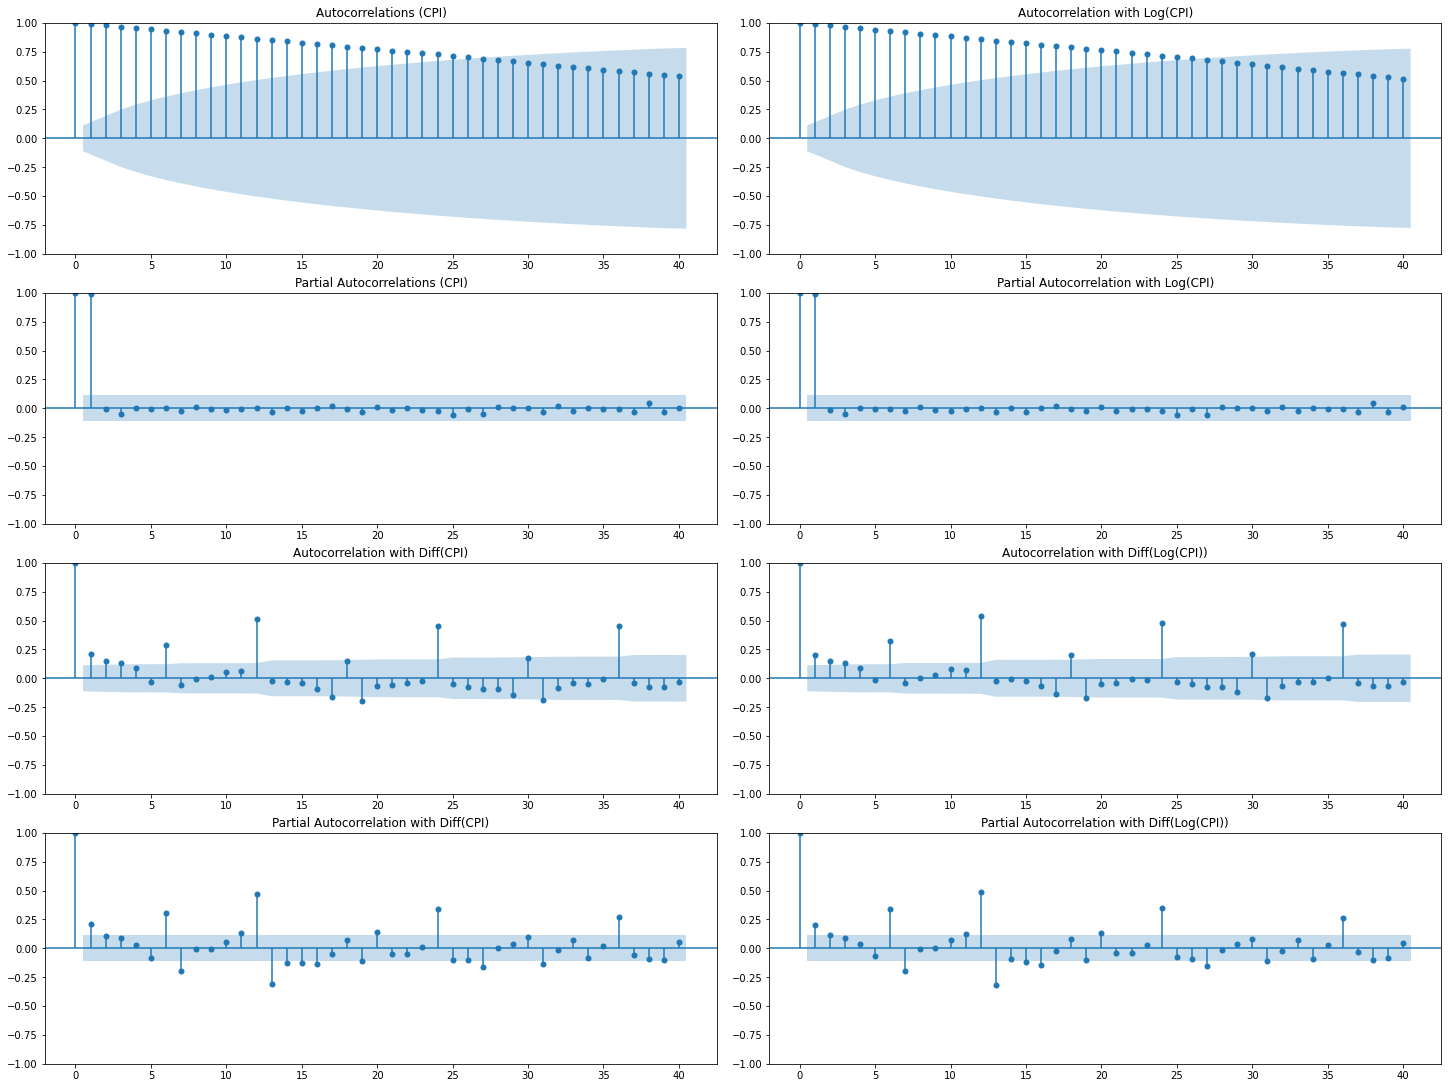

In [18]:
maxLags = 40

fig = plt.figure(figsize=(20,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_train, lags=maxLags, ax=ax_acf, title='Autocorrelations (' + serie + ')')
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_train, lags=maxLags, ax=ax_pacf, title='Partial Autocorrelations (' + serie + ')');

# Auto-correlation function for time series transformed with Log
ax_acfLog = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(np.log(df_train), lags=maxLags, ax=ax_acfLog, title='Autocorrelation with Log('+ serie + ')')
# Partial auto-correlation function for time series transformed with Log
ax_pacfLog = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train), lags=maxLags, ax=ax_pacfLog, title='Partial Autocorrelation with Log('+ serie + ')');

# Auto-correlation function for time series transformed with Diff
ax_acfDiff = fig.add_subplot(spec[2, 0])
sm.graphics.tsa.plot_acf(df_train.diff().dropna(), lags=maxLags, ax=ax_acfDiff, title='Autocorrelation with Diff('+ serie + ')')
# Partial auto-correlation function for time series transformed with Diff
ax_pacfDiff = fig.add_subplot(spec[3, 0])
sm.graphics.tsa.plot_pacf(df_train.diff().dropna(), lags=maxLags, ax=ax_pacfDiff, title='Partial Autocorrelation with Diff('+ serie + ')');

# Auto-correlation function for time series transformed with Log
ax_acfDiffLog = fig.add_subplot(spec[2, 1])
sm.graphics.tsa.plot_acf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_acfDiffLog, title='Autocorrelation with Diff(Log('+ serie + '))')
# Partial auto-correlation function for time series transformed with Log
ax_pacfDiffLog = fig.add_subplot(spec[3, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_pacfDiffLog, title='Partial Autocorrelation with Diff(Log('+ serie + '))');

plt.show()

# SARIMA Selection

Pre-processing From now on, we must choose whether we go with the Log(Time-Series) or not. This should be done to remove stationarity of the data, so that SARIMA can work. In addition, if the model is multiplicative we need to use log to make it additive as SARIMA relies on that assumption. The previously seen differentiated data enters in the I component of the SARIMA model it will take care of differenciating for us.

In [19]:
isLog = True

if (isLog):
    df_Train = pd.DataFrame(np.log(df_train), index = df_train.index).copy()
else:
    df_Train = df_train.copy()

# Model training

In this section we will train several SARIMA models based on distinct (p,d,q)t(P,D,Q)m combinations. Not only train but also forecast, and extract their AIC, BIC and HQIC.

In [20]:
# Range of SARIMA models to compute
class sarimaCfg:
    p_range = range(1, 3) # [1,8)
    d_range = range(1, 2) # [1,3)
    q_range = range(1, 2) # [1,8)
    t_range = ['n', 'c']
    P_range = range(1, 2) # [1,8)
    D_range = range(1, 2) # [1,3)
    Q_range = range(1, 2) # [1,8)
    m_range = range(12, 13) # [1,3) 

dict_sarimaFit, dict_sarimaPred, df_IC = SARIMA_grid(df_Train.values, sarimaCfg, isLog)

1/4 
2/4 
3/4 
4/4 


# Model Comparison based on Information Criteria

AIC - Akaike information criterion (AIC) is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. BIC - Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models. It is based, in part, on the likelihood function and it is closely related to AIC. HQIC - Hannan–Quinn information criterion (HQIC) is a criterion for model selection. It is an alternative to AIC and BIC.

In [21]:
print(df_IC[['AIC']].sort_values('AIC').head().rename(columns={'AIC': 'TOP 5 AIC'}))
print(" ")
print(df_IC[['BIC']].sort_values('BIC').head().rename(columns={'BIC': 'TOP 5 BIC'}))
print(" ")
print(df_IC[['HQIC']].sort_values('HQIC').head().rename(columns={'HQIC': 'TOP 5 HQIC'}))

                                 TOP 5 AIC
SARIMA(1, 1, 1)n(1, 1, 1, 12) -2537.229689
SARIMA(2, 1, 1)n(1, 1, 1, 12) -2513.453052
SARIMA(1, 1, 1)c(1, 1, 1, 12) -2510.756447
SARIMA(2, 1, 1)c(1, 1, 1, 12) -2502.642712
 
                                 TOP 5 BIC
SARIMA(1, 1, 1)n(1, 1, 1, 12) -2518.863073
SARIMA(2, 1, 1)n(1, 1, 1, 12) -2491.413113
SARIMA(1, 1, 1)c(1, 1, 1, 12) -2488.716508
SARIMA(2, 1, 1)c(1, 1, 1, 12) -2476.929449
 
                                TOP 5 HQIC
SARIMA(1, 1, 1)n(1, 1, 1, 12) -2529.871938
SARIMA(2, 1, 1)n(1, 1, 1, 12) -2504.623752
SARIMA(1, 1, 1)c(1, 1, 1, 12) -2501.927146
SARIMA(2, 1, 1)c(1, 1, 1, 12) -2492.341861


# Selected Models Information Criteria Comparison

Evaluate models based on their Information Criteria (IC)

Considering different combinations, the two models with the lowest IC values are:

SARIMA(2, 1, 1)c(1, 1, 1, 12) with a BIC of -2476.929449
SARIMA(1, 1, 1)c(1, 1, 1, 12) with an HQIC of -2501.927146
These models have the lowest values among the options provided, taking into account different IC criteria.

# Selected Models Information Criteria Comparison

Evaluate models based on their Information Criteria (IC)

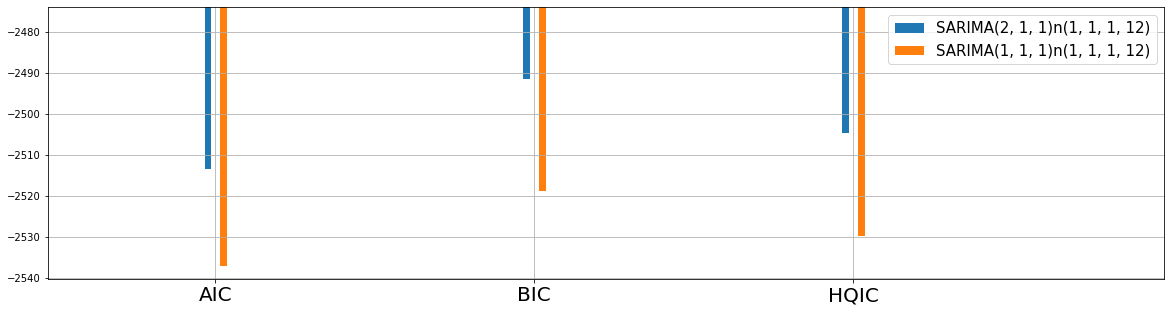

In [22]:
labels = ['SARIMA(2, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(1, 1, 1)n(1, 1, 1, 12)']

plt.figure(figsize=(20,5))
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
spacing = 0.05
barWidth = 0.025
r = np.arange(3) - ((len(labels)/2)-1)*spacing

for i in np.arange(len(labels)):
    plt.bar(r, df_IC.loc[labels[i]].values, width=barWidth, edgecolor='white', label=labels[i])
    r = [x + spacing for x in r]
 
plt.xticks([r + barWidth for r in range(3)], ['AIC', 'BIC', 'HQIC'], fontsize='20')
plt.axis((-0.5, 3.0, min(df_IC.min())-0.05*(max(df_IC.max())-min(df_IC.min())), max(df_IC.max())+0.05*(max(df_IC.max())-min(df_IC.min()))))
plt.legend(loc='best')
plt.grid()
plt.show()

# Selected Models Cross-Validation

Although IC provides an estimate of the quality of each model, relative to each of the other models. It does so by analyzing the models itself, and not having a look into the data. Another raised question is, which IC should be followed in this case. By applying cross-validation and having a look at the data itself, and the model, simultaneously. It will be possible to estimate the prediction performance, but also, which model is the most likely to perform better with un-seen data.

In [23]:
# get the number of rows in the training data
num_rows = len(df_train.values)

# print the number of rows
print(f'The number of rows in df_train is: {num_rows}')

The number of rows in df_train is: 304


In [24]:
labels = ['SARIMA(2, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(1, 1, 1)n(1, 1, 1, 12)']

# Select data to be used for cross-validation
Xcv, ycv = splitTrain.split_train_variableInput(sequence = df_Train.values[-304:], 
                                                minSamplesTrain = 200, 
                                                numOutputs = stepsToForecast[-1], 
                                                numJumps = 4)
dict_MAE = {} 
for model_str in labels:
    list_conv = list()
    list_mae = list()
    list_mape = list()
    print("%s" % model_str);
    for i in np.arange(len(Xcv)):
        try:
            model = SARIMAX(Xcv[i], order=parse_tuple(model_str[6:15]), \
                                    trend=model_str[15],     \
                                    seasonal_order=parse_tuple(model_str[16:]));
            model_fit = model.fit(disp=0);

            if (~np.isnan(model_fit.mle_retvals.get('fopt'))):
                if (isLog):
                    predictions_array = np.e**(model_fit.forecast(steps=stepsToForecast[-1])[0]);
                else:
                    predictions_array = model_fit.forecast(steps=stepsToForecast[-1])[0];

                list_conv.append(i+1)

                mae = horizon_mae(ycv[i], predictions_array, stepsToForecast)
                list_mae.append(mae)

                mape = horizon_mape(ycv[i], predictions_array, stepsToForecast)
                list_mape.append(mape)

                print("%d/%d" % (i+1, len(Xcv)));
        except:
            continue
    print("")

    dict_MAE[model_str] =  {'conv': list_conv, 'mae': list_mae, 'mape': list_mape}  

SARIMA(2, 1, 1)n(1, 1, 1, 12)
1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
24/24

SARIMA(1, 1, 1)n(1, 1, 1, 12)
1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
24/24



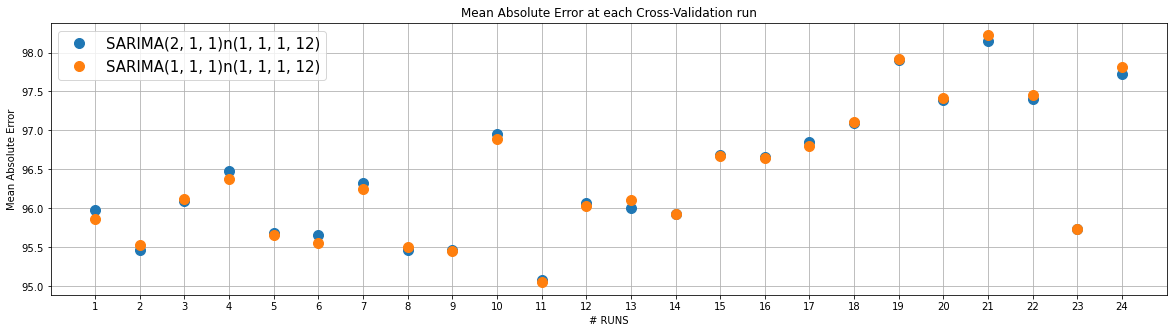

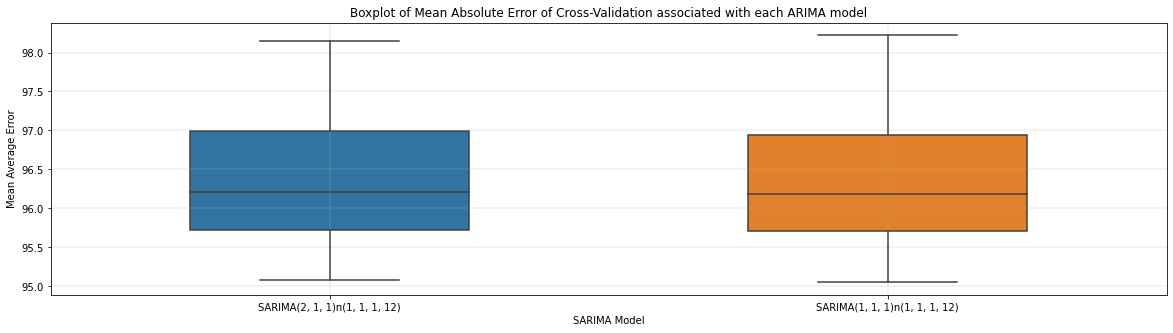

SARIMA(2, 1, 1)n(1, 1, 1, 12)
Prediction for 12 Months/Year: MAE = 96.43 (2088.08%)
SARIMA(1, 1, 1)n(1, 1, 1, 12)
Prediction for 12 Months/Year: MAE = 96.42 (2087.97%)


In [25]:
labels = ['SARIMA(2, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(1, 1, 1)n(1, 1, 1, 12)']

# Select index of stepsToForecast to assess cross-validation from
PRED_IX = 3


plt.figure(figsize=(20,5));
for model_str in labels:
    plt.plot(dict_MAE[model_str]['conv'], [mae[PRED_IX-1] for mae in dict_MAE[model_str]['mae']], 'o', markersize=10)
plt.legend(labels)
plt.xlabel('# RUNS')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error at each Cross-Validation run')
if (len(Xcv) > 500):
    plt.xticks(np.arange(0, len(Xcv), 100))
if (len(Xcv) > 250):
    plt.xticks(np.arange(0, len(Xcv), 50))
elif (len(Xcv) > 50):
    plt.xticks(np.arange(0, len(Xcv), 10))
else:
    plt.xticks(np.arange(1,len(Xcv)+1))
plt.xlim([0, len(Xcv)+1])
plt.grid()
plt.show();

plt.figure(figsize=(20, 5))
y_bp = []
x_bp = np.empty((0))
for model_str in labels:
    if (len(dict_MAE[model_str]['conv'])>0):
        maeVals = [mae[PRED_IX-1] for mae in dict_MAE[model_str]['mae']]
        y_bp.extend(maeVals)
        x_bp = np.append(x_bp, np.repeat(model_str, len(maeVals)))
        df_bp = pd.DataFrame(data={'SARIMA Model': x_bp, 'Mean Average Error': y_bp})
bplot=sns.boxplot(y='Mean Average Error', x='SARIMA Model', data=df_bp, width=0.5) 
plt.title('Boxplot of Mean Absolute Error of Cross-Validation associated with each ARIMA model');
plt.grid(linewidth=.3)
plt.show();

for i in np.arange(len(labels)):
    if (len(dict_MAE[labels[i]]['conv'])>0):
        print(labels[i])
        print('Prediction for ' + str(stepsToForecast[PRED_IX-1]) + ' ' + xlab + ': MAE = ' \
              + str(round(np.mean([mae[PRED_IX-1] for mae in dict_MAE[labels[i]]['mae']]), 2)) \
              + ' (' + str(round(np.mean([mape[PRED_IX-1] for mape in dict_MAE[labels[i]]['mape']]), 2)) + '%)' )

# Model Validation

This section allows to validate the selected model

In [26]:
# Pick you favourite's models order

# (1,1,1)n(1,1,1,12)
order = (1, 1, 1)
trend = 'n'
seasonal_order= (1, 1, 1, 12)

model = SARIMAX(df_Train.values, order=order, trend=trend, seasonal_order=seasonal_order)
model_fit = model.fit(disp=0);
df_res = pd.DataFrame({"resid": model_fit.resid}, index= df_Train.index)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  304
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1273.615
Date:                            Thu, 18 May 2023   AIC                          -2537.230
Time:                                    11:54:25   BIC                          -2518.863
Sample:                                         0   HQIC                         -2529.872
                                            - 304                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7877      0.066     11.978      0.000       0.659       0.917
ma.L1         -0.4422      0.092     -4.825      0.000      -0.622      -0.263
ar.S.L12      -0.0337      0.073     -0.459      0.646      -0.178       0.110
ma.S.L12      -0.8203      0.050    -16.437      0.000      -0.918      -0.722
sigma2       8.78e-06   6.77e-07     12.970      0.000    7.45e-06    1.01e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.89   Prob(JB):                         0.12
Heteroskedasticity (H):               1.10   Skew:                            -0.10
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Model Residual Analysis

Plots residual and its histogram.

Clearly there are outliers at the beggining, in order to not interfere with our residual analysis we will find these with an IQR algorithm applied at the beggining of the time series and replaced them by 0

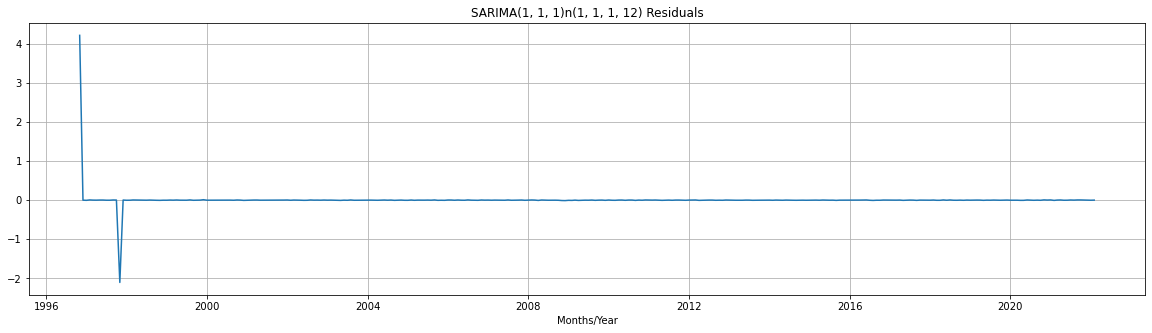

In [27]:
# Plot model residuals
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals')
plt.grid()
plt.show()

The following plot results from the residuals depicted above by replacing: 
1996-11-01: 4.2166 to 0.0000
1997-11-01: -2.1054 to 0.0000


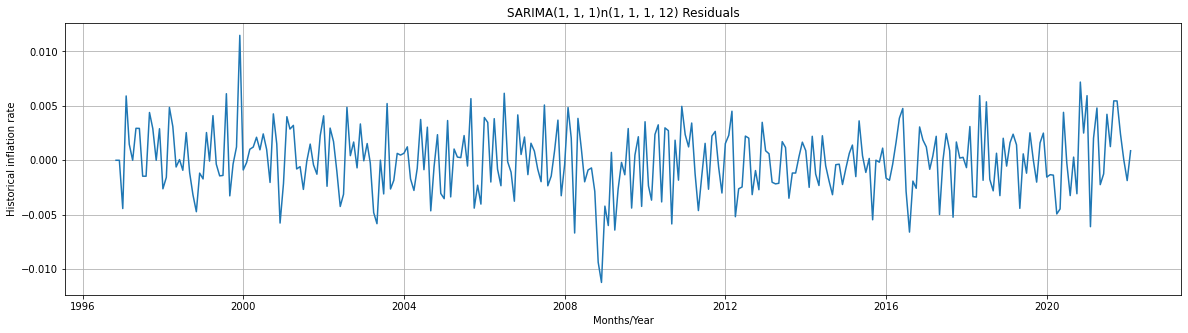

In [28]:
df_resNew, outliers = replace_initial_outliers(df_res, seasonal_periods*5, 0, 3.5)

print("The following plot results from the residuals depicted above by replacing: ")
for key, value in outliers:
    print("%s: %.4f to 0.0000" % (key, value));

plt.figure(figsize=(20,5))
plt.plot(df_resNew.index, df_resNew.values)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals')
plt.grid()
plt.show()

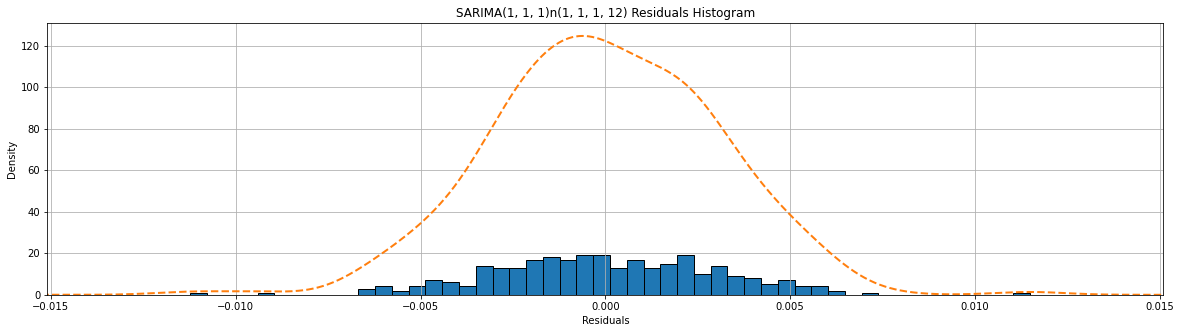

Mean: -0.000004
Variance: 0.000009


In [29]:
# Plot histogram
plt.figure(figsize=(20,5))
plt.title('SARIMA' + str(order) + trend + str(seasonal_order) + ' Residuals Histogram')
hist_res = df_resNew['resid'].hist(bins=50, edgecolor='black')
df_resNew['resid'].plot(kind='kde', linewidth=2, linestyle='--')
plt.xlabel('Residuals')
limX = np.mean(df_resNew.values)+5*np.std(df_resNew.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

print ("Mean: %.6f" % np.mean(df_resNew))
print ("Variance: %.6f" % np.var(df_resNew))

# Normality Test

Kurtosis and Kurtosis Test Compute the kurtosis (Fisher or Pearson) of a dataset. Kurtosis is the fourth central moment divided by the square of the variance. If Fisher's definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution. If bias is False then the kurtosis is calculated using k statistics to eliminate bias coming from biased moment estimators

Test whether a dataset has normal kurtosis. This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1).

In [30]:
k, kpval = kurtosistest(df_resNew['resid'].values)
kurtosis_val = kurtosis(df_resNew['resid'].values, fisher=True)
# If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)

Kurtosis Test
Statistic: 1.8447
p-value: 0.0651
Kurtosis value: 0.5608


In [31]:
s, spval = skewtest(df_resNew['resid'].values)
skew_val = skew(df_resNew['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val)

Skew Test
Statistic: -0.4010
p-value: 0.6884
Skewness value: -0.0551


In [32]:
jb, jbpval= stats.jarque_bera(df_resNew['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)

print(" ")

ks, kspval = stats.kstest(df_resNew['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Jarque-Bera Test
Statistic: 4.1377
p-value: 0.1263
 
Kolmogorov-Smirnov Test
Statistic: 0.4955
p-value: 0.0000


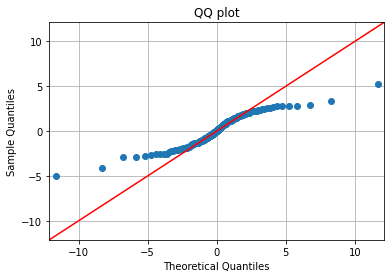

In [33]:
qqplot(df_resNew['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()
plt.show()

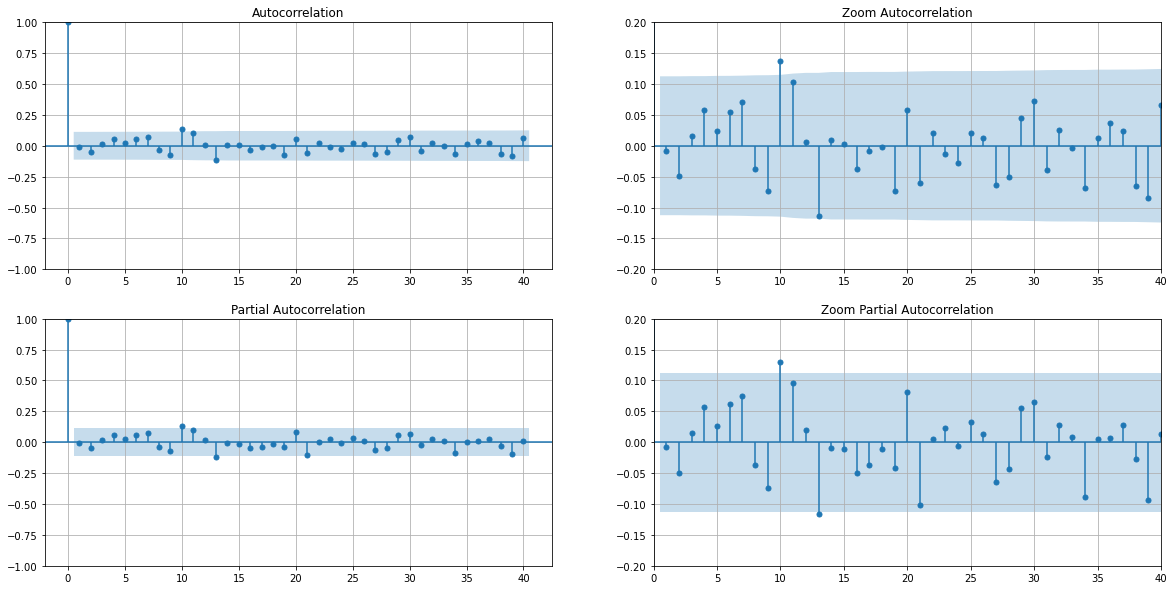

In [34]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_resNew['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_resNew['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_resNew['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_resNew['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));

plt.show()

# Model Prediction

This section allows to see the forecast of the model that was selected and validated.

In [35]:
# (1,1,1)n(1,1,1,12)
dict_sarimaPred['SARIMA(1, 1, 1)n(1, 1, 1, 12)']

array([108.4235755 , 108.7691499 , 108.96365421, 109.28897639,
       109.34754291, 109.73839392, 109.61894854, 109.54640361,
       109.56258712, 109.69353493, 109.17475891, 109.92530292])

In [36]:
dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)]

array([108.4235755 , 108.7691499 , 108.96365421, 109.28897639,
       109.34754291, 109.73839392, 109.61894854, 109.54640361,
       109.56258712, 109.69353493, 109.17475891, 109.92530292])

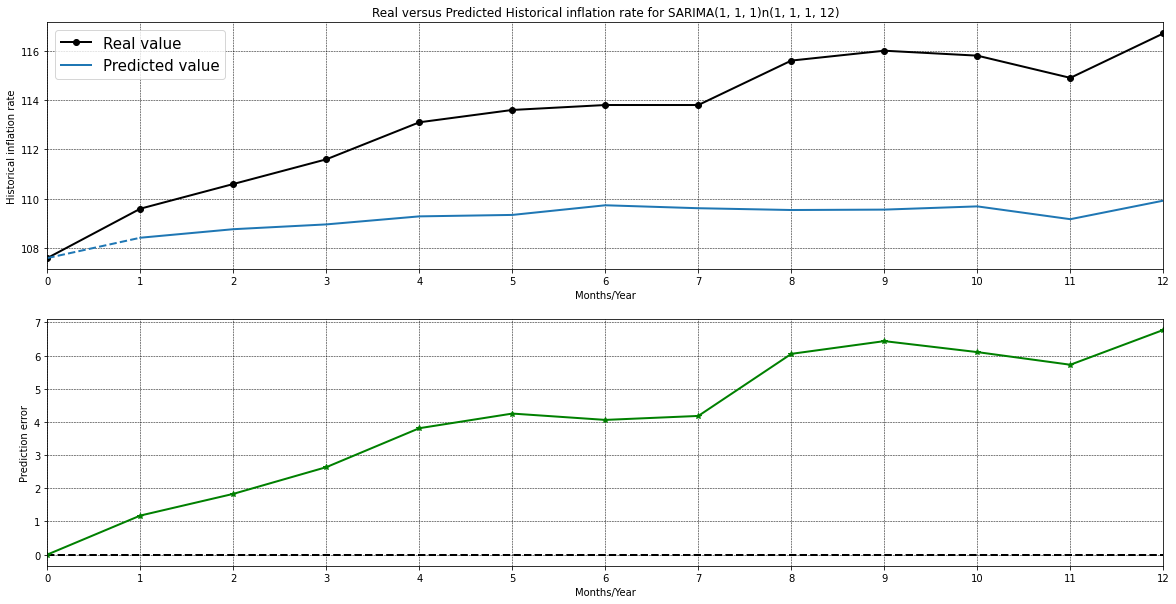

SARIMA(1, 1, 1)n(1, 1, 1, 12)
Prediction for 1 Months/Year: MAE = 1.18 (1.07%)
Prediction for 3 Months/Year: MAE = 1.88 (1.7%)
Prediction for 12 Months/Year: MAE = 4.42 (3.86%)


In [37]:
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab + ' for SARIMA' + str(order) + trend + str(seasonal_order))
plt.plot(range(0, stepsToForecast[-1]+1), np.concatenate((df_train.values[-1], df_test.values.flatten()), axis=0), 'k-o', linewidth=2)
plt.plot(range(1, stepsToForecast[-1]+1), dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)], color = cmap(0), linewidth=2)
plt.plot([0,1], [df_train.values[-1][0], dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)][0]], '--', color = cmap(0), linewidth=2)

plt.xlim([0,len(dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)])])
plt.xticks(np.arange(0, len(dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)])+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.plot(range(0,stepsToForecast[-1]+1), np.concatenate((np.array([0]), df_test.values.flatten()-dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)]), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, stepsToForecast[-1]+1, step=1))
plt.xlim([0, stepsToForecast[-1]])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

for i in np.arange(len(labels[1:])):
    mae  = horizon_mae(df_test.values, dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)], stepsToForecast)
    mape = horizon_mape(df_test.values, dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)], stepsToForecast)
    print(labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )

In [38]:
# Forecasted values of SARIMA model
dict_sarimaPred['SARIMA'+ str(order) + trend + str(seasonal_order)]

array([108.4235755 , 108.7691499 , 108.96365421, 109.28897639,
       109.34754291, 109.73839392, 109.61894854, 109.54640361,
       109.56258712, 109.69353493, 109.17475891, 109.92530292])

# Model Prediction (and comparison with others)
Compare: Fitted values of the model with the training data Predicted values of the model with the testing data

This section allows to see the forecast of the model that was selected and validated. But also, to compare it against other models.

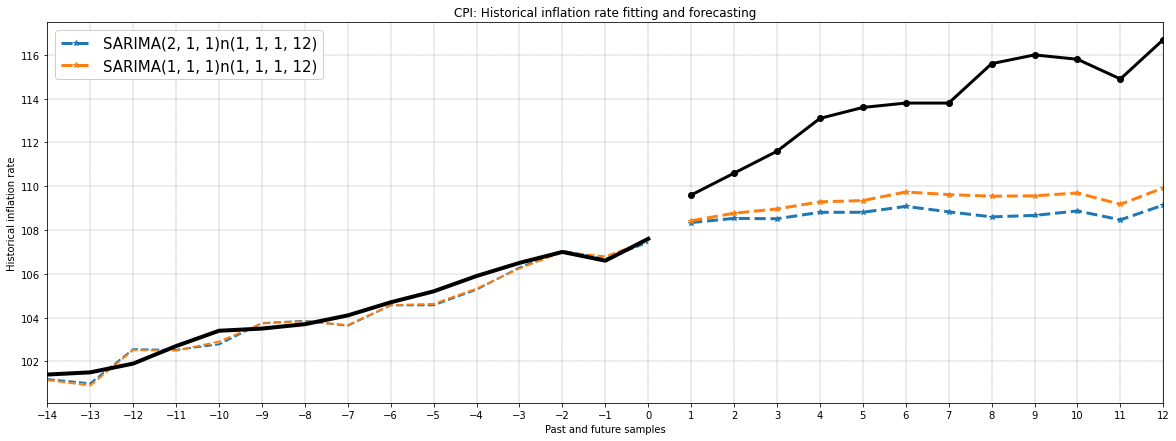

SARIMA(2, 1, 1)n(1, 1, 1, 12)
Prediction for 1 Months/Year: MAE = 1.26 (1.15%)
Prediction for 3 Months/Year: MAE = 2.14 (1.93%)
Prediction for 12 Months/Year: MAE = 5.04 (4.39%)

SARIMA(1, 1, 1)n(1, 1, 1, 12)
Prediction for 1 Months/Year: MAE = 1.18 (1.07%)
Prediction for 3 Months/Year: MAE = 1.88 (1.7%)
Prediction for 12 Months/Year: MAE = 4.42 (3.86%)



In [39]:
labels = ['Inflation rate',
          'SARIMA(2, 1, 1)n(1, 1, 1, 12)',
          'SARIMA(1, 1, 1)n(1, 1, 1, 12)']


plt.figure(figsize=(20,7))
previousStepsToShow = 15;
plt.title(title + ' fitting and forecasting')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3 )
for i in np.arange(len(labels)-1):
    sarimaPlot = plt.plot(1+np.arange(stepsToForecast[-1]), dict_sarimaPred[labels[i+1]], '--*' , linewidth = 3, label = labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_sarimaFit[labels[i+1]][-previousStepsToShow:], '--' , linewidth = 2, color=sarimaPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 )
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow,+stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future samples')
plt.ylabel(ylab);
plt.show()

for i in np.arange(len(labels[1:])):
    mae  = horizon_mae(df_test.values, dict_sarimaPred[labels[i+1]], stepsToForecast)
    mape = horizon_mape(df_test.values, dict_sarimaPred[labels[i+1]], stepsToForecast)
    print(labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )
    print("")